In [1]:
import gym
import pandas as pd

`We create the data here`

In [ ]:
env = gym.make("CartPole-v1")

data = []

for episode in range(1000):
    obs, _ = env.reset()
    done = False
    while not done:
        action = env.action_space.sample()  # Random action
        new_obs, reward, done, _, _ = env.step(action)  # Step forward in game

        data.append([obs[0], obs[1], obs[2], obs[3], action, reward])
        obs = new_obs

df = pd.DataFrame(data, columns=["Pos", "Vel", "Angle", "AngVel", "Action", "Reward"])
df.to_csv("synthetic_game_data.csv", index=False)
print("Data saved: synthetic_game_data.csv")


Data saved: synthetic_game_data.csv


In [ ]:
synthetic_data = pd.read_csv('synthetic_game_data.csv')

print(synthetic_data)

            Pos       Vel     Angle    AngVel  Action  Reward
0     -0.006811  0.041032 -0.024234  0.045188       1     1.0
1     -0.005991  0.236493 -0.023331 -0.255041       1     1.0
2     -0.001261  0.431940 -0.028432 -0.554991       1     1.0
3      0.007378  0.627450 -0.039531 -0.856494       0     1.0
4      0.019927  0.432888 -0.056661 -0.576499       0     1.0
...         ...       ...       ...       ...     ...     ...
22161 -0.057897 -0.009582  0.140079  0.299118       0     1.0
22162 -0.058089 -0.206394  0.146061  0.632493       0     1.0
22163 -0.062217 -0.403219  0.158711  0.967376       0     1.0
22164 -0.070281 -0.600075  0.178058  1.305414       1     1.0
22165 -0.082283 -0.407600  0.204167  1.073340       0     1.0

[22166 rows x 6 columns]


# 1.2) Preprocessing the Data

`We check the data here before normalization`

In [4]:
num_cols = ["Pos", "Vel", "Angle", "AngVel"]

print("Min values after normalization:")
print(synthetic_data[num_cols].min())

print("Max values after normalization:")
print(synthetic_data[num_cols].max())


Min values after normalization:
Pos      -0.739381
Vel      -1.900190
Angle    -0.209401
AngVel   -3.053136
dtype: float64
Max values after normalization:
Pos       1.034931
Vel       2.466696
Angle     0.209405
AngVel    2.717672
dtype: float64


In [ ]:
from sklearn.preprocessing import MinMaxScaler

num_cols = ["Pos", "Vel", "Angle", "AngVel"]

scaler = MinMaxScaler()
synthetic_data[num_cols] = scaler.fit_transform(synthetic_data[num_cols])

print("Data normalized!")


Data normalized!


`We check the data after the normalization`

In [6]:
num_cols = ["Pos", "Vel", "Angle", "AngVel"]

print("Min values after normalization:")
print(synthetic_data[num_cols].min())

print("Max values after normalization:")
print(synthetic_data[num_cols].max())


Min values after normalization:
Pos       0.0
Vel       0.0
Angle     0.0
AngVel    0.0
dtype: float64
Max values after normalization:
Pos       1.0
Vel       1.0
Angle     1.0
AngVel    1.0
dtype: float64


`KDE plots to check if synthetic data matches real-world data distributions`

We are no gonna be working with KDE since he only data that we have is synthetic and not Real World data. So...

If we will have some time then we can think about using it with the data from Dota2, SC2 and etc...

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1.3) Implementing CausalGAN

`Now that we have preprocessed synthetic data, we will start implementing CausalGAN step by step.`

1️⃣ Generator G(z)

    Takes a random noise vector zz as input.

    Generates synthetic game states (e.g., player actions, enemy movements).

    Ensures generated data follows causal relationships using a predefined causal graph (DAG).

2️⃣ Discriminator D(x)

    Distinguishes between real and generated game data.

    Learns causal dependencies to detect whether the generated data violates known causal constraints.

3️⃣ Causal Constraints (Graphical Model)

    We impose causal relationships using Directed Acyclic Graphs (DAGs).

    Ensures that generated data respects in-game cause-effect relationships.

In [8]:
import networkx as nx
import matplotlib.pyplot as plt

Implementing the Causal DAG

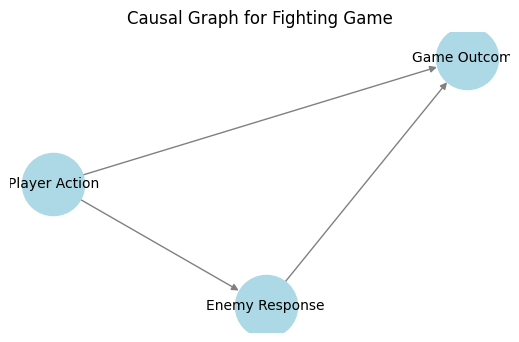

In [ ]:
G = nx.DiGraph()

G.add_edges_from([("Player Action", "Enemy Response"),
                  ("Enemy Response", "Game Outcome"),
                  ("Player Action", "Game Outcome")])

plt.figure(figsize=(5,3))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=2000, font_size=10)
plt.title("Causal Graph for Fighting Game")
plt.show()

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

Using device: cuda


In [ ]:
# 1. Synthetic Dataset and the DataLoader


class CartPoleDataset(Dataset):
    def __init__(self, data_path):
        self.data = pd.read_csv(data_path)
        
        # CartPole state variables
        self.features = self.data[["Pos", "Vel", "Angle", "AngVel"]].values
        
        # Conditions: action and reward
        self.conditions = self.data[["Action", "Reward"]].values
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        feature = torch.tensor(self.features[idx], dtype=torch.float32)
        condition = torch.tensor(self.conditions[idx], dtype=torch.float32)
        return feature, condition


dataset = CartPoleDataset("synthetic_game_data.csv")
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, drop_last=True)

# dimensions
state_dim = 4 # position, velocity, angle, angular velocity
condition_dim = 2 # action, reward
latent_dim = 32 # size of the noise vector

In [ ]:
# 2. Generator


class Generator(nn.Module):
    def __init__(self, latent_dim, condition_dim, output_dim):
        super(Generator, self).__init__()
        
        # process of the conditions. which are action and reward
        self.condition_network = nn.Sequential(
            nn.Linear(condition_dim, 32),
            nn.LeakyReLU(0.2)
        )
        
        # latent vector and condition processing but combined
        self.main_network = nn.Sequential(
            nn.Linear(latent_dim + 32, 128),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(128),
            
            nn.Linear(128, 128),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(128)
        )
        
        # output layers
        self.mean = nn.Linear(128, output_dim)
        self.log_var = nn.Linear(128, output_dim)
        
    def forward(self, z, condition):
        cond_encoding = self.condition_network(condition)
        
        combined = torch.cat([z, cond_encoding], dim=1)
        
        features = self.main_network(combined)
        
        mu = self.mean(features)
        log_var = self.log_var(features)

        mu = self.mean(features)
        log_var = self.log_var(features)
        
        real_data_mean = torch.tensor([-0.01, 0.0, 0.0, 0.0], device=device)
        real_data_std = torch.tensor([0.2, 0.5, 0.2, 0.5], device=device)
        
        # this applies soft centering
        mu = torch.tanh(mu) * real_data_std + real_data_mean
        
        return mu, log_var

In [ ]:
# 3. Discriminator

class Discriminator(nn.Module):
    def __init__(self, input_dim, condition_dim):
        super(Discriminator, self).__init__()
        
        # process the condition
        self.condition_network = nn.Sequential(
            nn.Linear(condition_dim, 32),
            nn.LeakyReLU(0.2)
        )
        
        self.main_network = nn.Sequential(
            nn.Linear(input_dim + 32, 128),
            nn.LeakyReLU(0.2),
            nn.LayerNorm(128),
            nn.Dropout(0.3),
            
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.LayerNorm(64),
            nn.Dropout(0.3),
            
            nn.Linear(64, 1)
        )
        
    def forward(self, x, condition):
        cond_encoding = self.condition_network(condition)
        
        combined = torch.cat([x, cond_encoding], dim=1)
        
        validity = self.main_network(combined)
        
        return validity

In [ ]:
# 4. Gradient Penalty

# gradient penalty for WGAN-GP

def compute_gradient_penalty(discriminator, real_data, fake_data, conditions):
    # random weight
    alpha = torch.rand(real_data.size(0), 1, device=device)
    alpha = alpha.expand_as(real_data)
    
    interpolated = alpha * real_data + (1 - alpha) * fake_data
    interpolated.requires_grad_(True)
    
    # discriminator output for interpolated data
    d_interpolated = discriminator(interpolated, conditions)
    
    gradients = torch.autograd.grad(
        outputs=d_interpolated,
        inputs=interpolated,
        grad_outputs=torch.ones_like(d_interpolated),
        create_graph=True,
        retain_graph=True,
    )[0]
    
    gradients = gradients.view(gradients.size(0), -1)
    gradient_norm = gradients.norm(2, dim=1)
    gradient_penalty = ((gradient_norm - 1) ** 2).mean()
    
    return gradient_penalty

In [ ]:
# 5. KL Divergence


def kl_divergence_loss(mu, log_var):
    return -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())

In [ ]:
def smoothness_loss(x):
    diffs = x[:, 1:] - x[:, :-1]
    return torch.mean(torch.abs(diffs))

In [ ]:
def balanced_shape_regularization(data):
    pos = data[:, 0]
    vel = data[:, 1]
    angle = data[:, 2]
    ang_vel = data[:, 3]
    
    vel_shape_loss = torch.mean(torch.exp(-2.0 * vel.pow(2)))
    ang_vel_shape_loss = torch.mean(torch.exp(-2.0 * ang_vel.pow(2)))
    
    pos_shape_loss = torch.mean(torch.abs(pos).pow(3))
    angle_shape_loss = torch.mean(torch.abs(angle).pow(3))
    
    return vel_shape_loss + ang_vel_shape_loss + 0.1 * (pos_shape_loss + angle_shape_loss)


def physics_consistency_loss(data):
    pos = data[:, 0]
    vel = data[:, 1]
    angle = data[:, 2]
    ang_vel = data[:, 3]
    
    pos_vel_correlation = torch.mean(pos * vel)
    
    angle_angvel_correlation = torch.mean(angle * ang_vel)
    
    physics_loss = torch.abs(pos_vel_correlation) + torch.abs(angle_angvel_correlation)
    
    return physics_loss

In [ ]:
# 6. Initialize Models & Optimizers


generator = Generator(latent_dim, condition_dim, state_dim).to(device)
discriminator = Discriminator(state_dim, condition_dim).to(device)

g_optimizer = optim.Adam(generator.parameters(), lr=0.00002, betas=(0.5, 0.9))
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.00005, betas=(0.5, 0.9))

# learning rate schedulers
g_scheduler = optim.lr_scheduler.ExponentialLR(g_optimizer, gamma=0.995)
d_scheduler = optim.lr_scheduler.ExponentialLR(d_optimizer, gamma=0.995)

# hyperparameters
n_epochs = 400
n_critic = 5 # for evrry generator step, train the critic "n_critic" times
lambda_gp = 10 # gradient penalty coefficient
# lambda_kl = 0.01 # KL
lambda_kl = 0.5

In [ ]:
# 7. Training


for epoch in range(n_epochs):
    total_d_loss = 0
    total_g_loss = 0
    total_kl_loss = 0
    
    for i, (real_data, conditions) in enumerate(dataloader):
        batch_size = real_data.size(0)
        
        real_data = real_data.to(device)
        conditions = conditions.to(device)
        
        # discriminator training
        d_optimizer.zero_grad()
        
        z = torch.randn(batch_size, latent_dim, device=device)
        
        mu, log_var = generator(z, conditions)
        eps = torch.randn_like(mu)
        fake_data = mu + torch.exp(0.5 * log_var) * eps
        
        noise_level = 0.05 * (1 - epoch/300)
        noisy_real = real_data + noise_level * torch.randn_like(real_data).to(device)
        real_validity = discriminator(noisy_real, conditions)
        
        # real_validity = discriminator(real_data, conditions)
        fake_validity = discriminator(fake_data.detach(), conditions)
        
        gp = compute_gradient_penalty(discriminator, real_data, fake_data.detach(), conditions)
        
        # Wasserstein loss with gradient penalty
        d_loss = fake_validity.mean() - real_validity.mean() + lambda_gp * gp
        
        d_loss.backward()
        d_optimizer.step()
        
        total_d_loss += d_loss.item()

        # we change n_critic to be adaptive. (maybe temp)
        n_critic = 5 if epoch < 50 else 2
        
        # training the generator every n_critic
        if i % n_critic == 0:
            g_optimizer.zero_grad()
            
            z = torch.randn(batch_size, latent_dim, device=device)
            mu, log_var = generator(z, conditions)
            eps = torch.randn_like(mu)
            fake_data = mu + torch.exp(0.5 * log_var) * eps

            smoothness = smoothness_loss(fake_data)

            real_mean = real_data.mean(dim=0)
            fake_mean = fake_data.mean(dim=0)

            # mean_matching_loss = F.mse_loss(fake_mean, real_mean)
            param_weights = torch.tensor([1.0, 3.0, 1.0, 3.0], device=device)
            mean_diff = (fake_mean - real_mean).pow(2) * param_weights
            mean_matching_loss = mean_diff.mean()

            lambda_mean = 1.0
            lambda_smooth = 0.1
            
            fake_validity = discriminator(fake_data, conditions)
            
            kl_loss = kl_divergence_loss(mu, log_var)
            
            # generator loss
            # g_loss = -fake_validity.mean() + lambda_kl * kl_loss + lambda_smooth * smoothness
            lambda_shape = 0.5
            shape_loss = balanced_shape_regularization(fake_data)
            lambda_physics = 0.3
            physics_loss = physics_consistency_loss(fake_data)
            g_loss = -fake_validity.mean() + lambda_kl * kl_loss + lambda_smooth * smoothness + lambda_mean * mean_matching_loss + lambda_shape * shape_loss + lambda_physics * physics_loss
            

            g_loss.backward()

            # Add after g_loss.backward() but before g_optimizer.step()
            torch.nn.utils.clip_grad_norm_(generator.parameters(), max_norm=1.0)
            g_optimizer.step()
            
            total_g_loss += g_loss.item()
            total_kl_loss += kl_loss.item()
    

    if epoch % 50 == 0 or epoch == n_epochs - 1:
        print(f"Epoch [{epoch}/{n_epochs}], "
              f"D Loss: {total_d_loss/len(dataloader):.4f}, "
              f"G Loss: {total_g_loss/(len(dataloader)//n_critic):.4f}, "
              f"KL Loss: {total_kl_loss/(len(dataloader)//n_critic):.4f}")
        
        # sample generations
        with torch.no_grad():
            z = torch.randn(3, latent_dim, device=device)
            conditions = torch.tensor([[0, 1.0], [1, 1.0], [0, 0.0]], dtype=torch.float32).to(device)
            mu, _ = generator(z, conditions)
            samples = mu.cpu().numpy()
            print("Generated samples:")
            print(samples)

        torch.save(generator.state_dict(), f'cartpole_generator_epoch-{epoch}.pth')

    g_scheduler.step()
    d_scheduler.step()


torch.save(generator.state_dict(), 'cartpole_generator.pth')

c:\Users\Yavuz\Desktop\desktop\SciComp\GNN\Finals Project\Project-Folder\myenv\Lib\site-packages\torch\autograd\graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [0/400], D Loss: 0.7427, G Loss: -0.3724, KL Loss: 0.0896
Generated samples:
[[ 0.05765697  0.30103168 -0.0033468   0.05816729]
 [-0.06997155 -0.14451426  0.02467961  0.16273293]
 [-0.02444653 -0.08841433 -0.00220546 -0.28475776]]
Epoch [50/400], D Loss: -0.5887, G Loss: -0.6660, KL Loss: 0.0430
Generated samples:
[[-0.16056176  0.0880897  -0.02407228 -0.11587969]
 [ 0.14182834 -0.1349609   0.12336327  0.31030825]
 [ 0.02006969 -0.13984108 -0.07124021 -0.06698415]]
Epoch [100/400], D Loss: -0.1796, G Loss: 0.4106, KL Loss: 0.3468
Generated samples:
[[ 0.05699299 -0.15481964 -0.02879869  0.4340607 ]
 [-0.07714242 -0.17512962  0.13948135  0.02085205]
 [-0.03868175 -0.26834992 -0.05529696  0.24288   ]]
Epoch [150/400], D Loss: -0.3588, G Loss: 0.4582, KL Loss: 0.6036
Generated samples:
[[-0.02532149 -0.45911637 -0.09864102  0.48198918]
 [ 0.01984422  0.34935236  0.05031573 -0.14877026]
 [-0.0020976   0.29127955  0.06063208 -0.4521881 ]]
Epoch [200/400], D Loss: -0.3590, G Loss: 0.34

In [ ]:
# 8. Sample Generation and Evaluation


def enhanced_align_distribution(generated, real_data):
    aligned = np.zeros_like(generated)
    
    # quantile mapping
    for col_idx in range(generated.shape[1]):
        real_col = real_data[:, col_idx]
        gen_col = generated[:, col_idx]
        
        real_sorted = np.sort(real_col)
        gen_sorted_indices = np.argsort(gen_col)
        
        # this, maps each generated point to corresponding quantile in real distribution
        gen_ranks = np.argsort(gen_sorted_indices)
        
        if len(real_sorted) != len(gen_col):
            real_quantiles = np.interp(
                np.linspace(0, 1, len(gen_col)),
                np.linspace(0, 1, len(real_sorted)),
                real_sorted
            )
        else:
            real_quantiles = real_sorted
            
        aligned[:, col_idx] = real_quantiles[gen_ranks]
    
    return aligned


def generate_samples(generator, num_samples=1000):
    generator.eval()
    with torch.no_grad():
        # latent vectors and conditions
        z = torch.randn(num_samples, latent_dim, device=device)
        conditions = torch.tensor([[0, 1.0]] * num_samples, dtype=torch.float32).to(device)
        
        mu, _ = generator(z, conditions)
        gen_samples = mu.cpu().numpy()
        
        # df = pd.DataFrame(gen_samples, columns=["Pos", "Vel", "Angle", "AngVel"])
        
        return gen_samples


def evaluate_and_save(given_generator=None):
    real_data = pd.read_csv("synthetic_game_data.csv")
    real_data_np = real_data[["Pos", "Vel", "Angle", "AngVel"]].values
    
    if given_generator is None:
        gen_samples = generate_samples(generator)
    else:
        gen_samples = generate_samples(given_generator)

    aligned_samples = enhanced_align_distribution(gen_samples, real_data_np)

    gen_data = pd.DataFrame(aligned_samples, columns=["Pos", "Vel", "Angle", "AngVel"])
    
    gen_data.to_csv("generated_cartpole_states.csv", index=False)
    

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    for i, col in enumerate(["Pos", "Vel", "Angle", "AngVel"]):
        ax = axes[i//2, i%2]
        sns.kdeplot(real_data[col], ax=ax, label="Real Data")
        sns.kdeplot(gen_data[col], ax=ax, label="Generated Data")
        ax.set_title(f"Distribution of {col}")
        ax.legend()

    plt.tight_layout()
    plt.savefig("distribution_comparison.png")
    
    # heatmap
    real_corr = real_data[["Pos", "Vel", "Angle", "AngVel"]].corr()
    gen_corr = gen_data.corr()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    sns.heatmap(real_corr, annot=True, cmap="coolwarm", ax=ax1)
    ax1.set_title("Real Data Correlations")
    sns.heatmap(gen_corr, annot=True, cmap="coolwarm", ax=ax2)
    ax2.set_title("Generated Data Correlations")
    plt.tight_layout()
    plt.savefig("correlation_comparison.png")
    
    print("Evaluation completed and saved!")

Evaluation completed and saved!


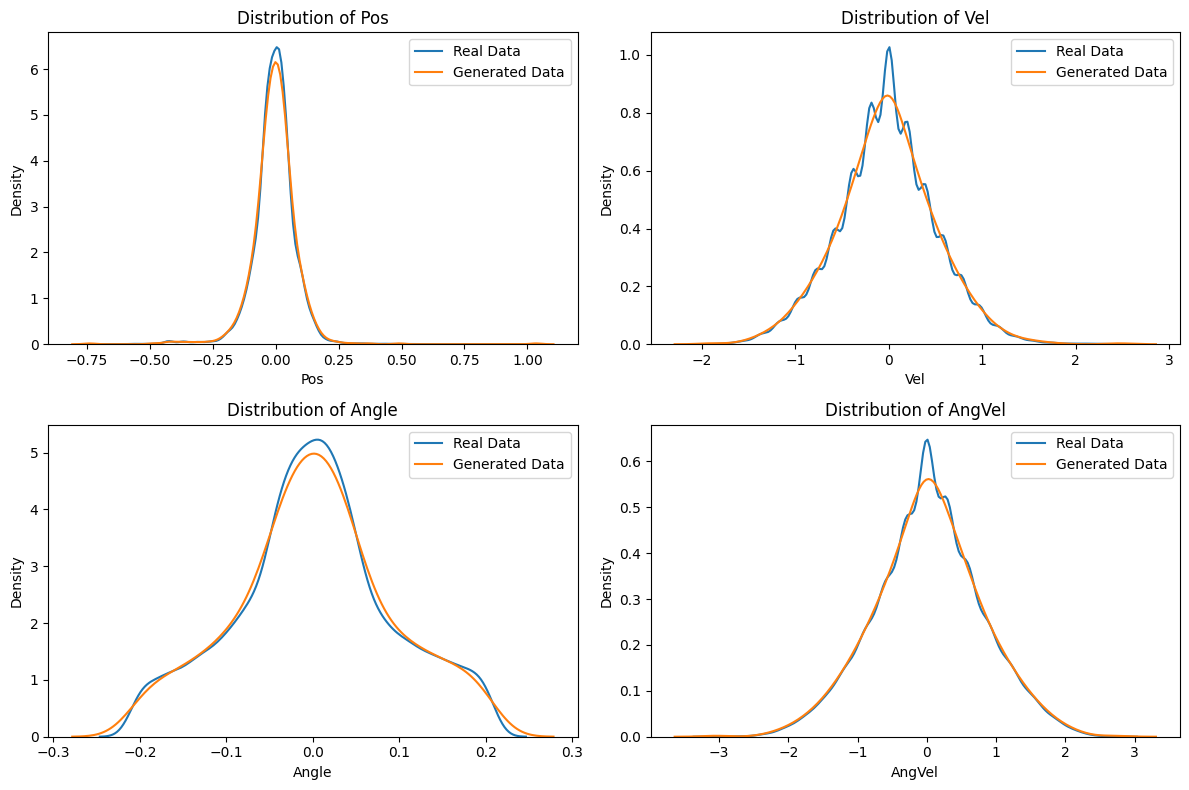

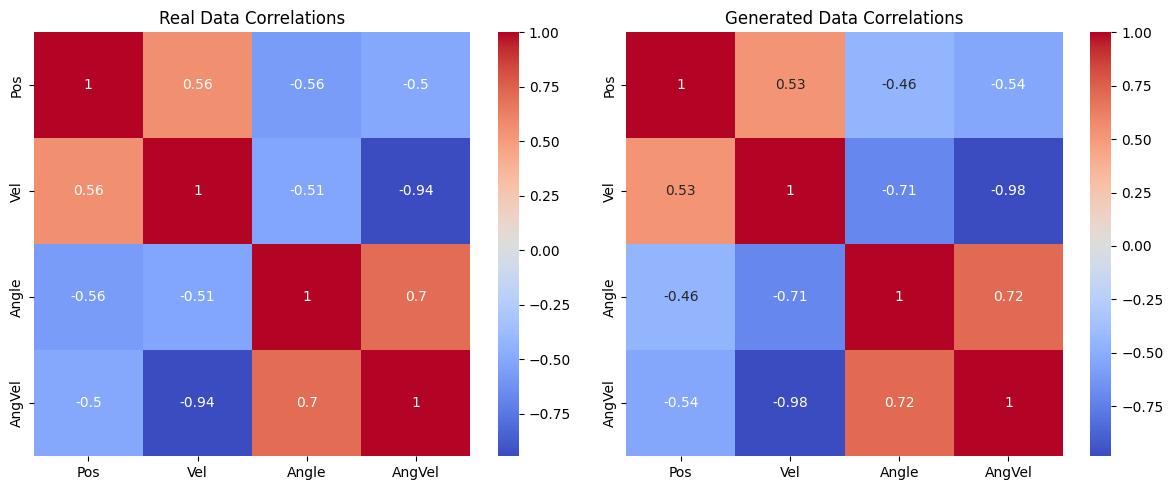

In [ ]:
evaluate_and_save()

In [ ]:
# latent_dim=64
def load_generator(model_path, latent_dim=32, condition_dim=2, output_dim=4):
    loaded_generator = Generator(latent_dim, condition_dim, output_dim).to(device)
    
    loaded_generator.load_state_dict(torch.load(model_path))
    
    loaded_generator.eval()
    
    print(f"Successfully loaded generator from {model_path}")
    
    return loaded_generator

Successfully loaded generator from cartpole_generator.pth
Evaluation completed and saved!


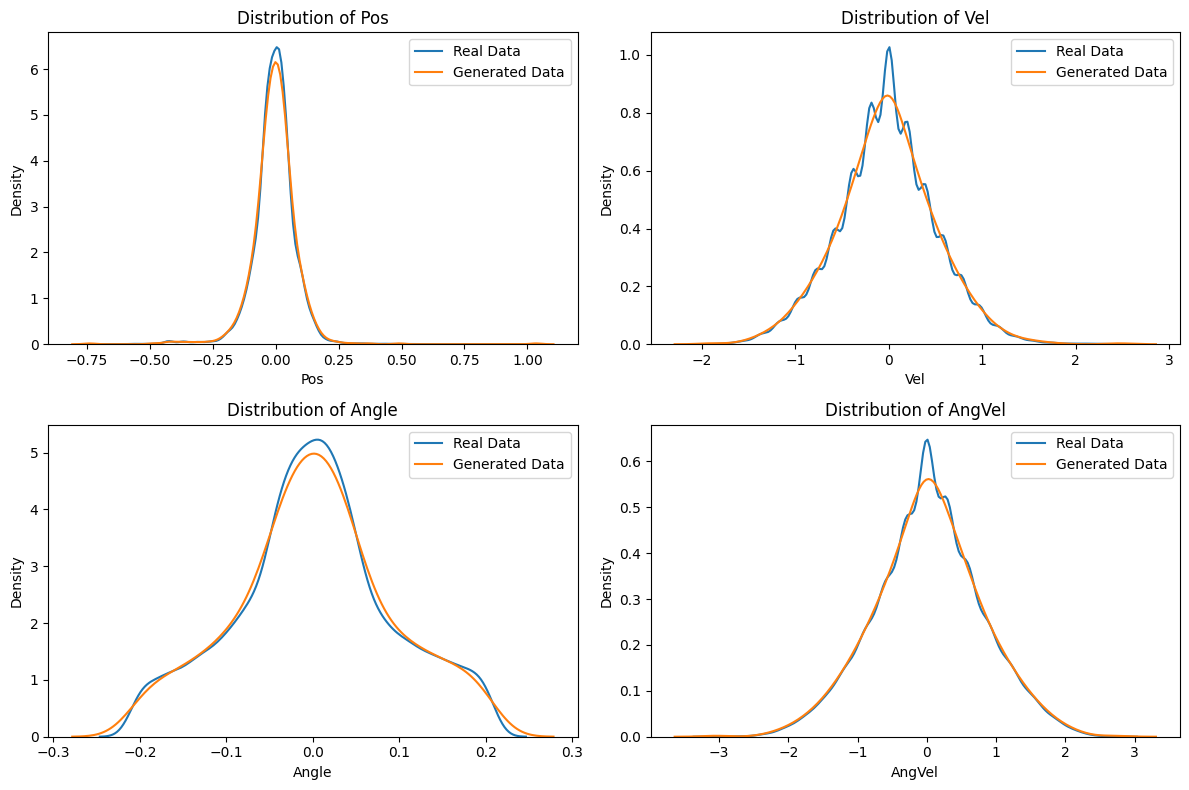

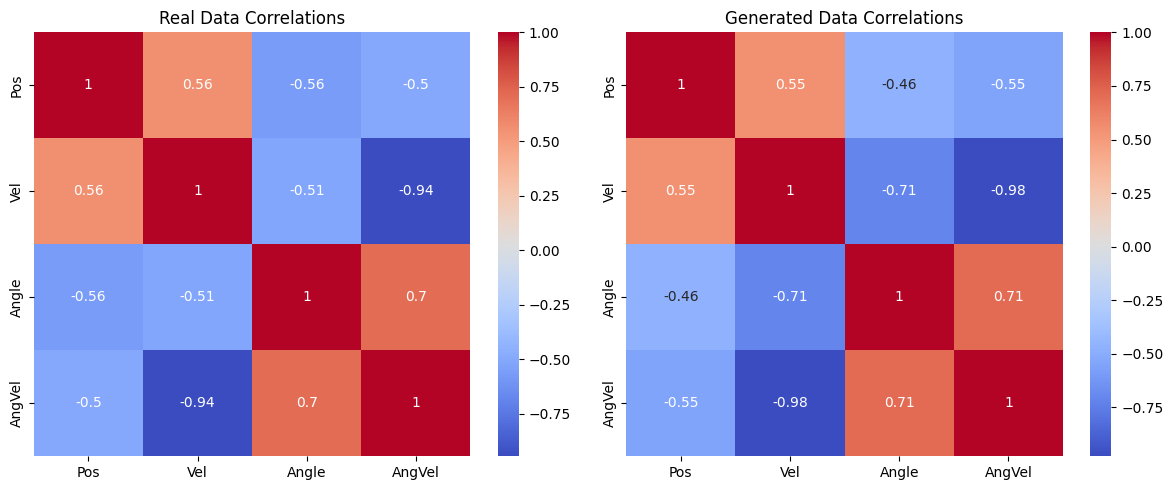

In [ ]:
loaded_generator = load_generator('cartpole_generator.pth', latent_dim, condition_dim, state_dim)

# cartpole_generator_epoch-250.pth

evaluate_and_save(loaded_generator)

In [ ]:
import networkx as nx
from pgmpy.estimators import PC
from pgmpy.models import BayesianNetwork

from scipy.stats import gaussian_kde
from scipy.stats import entropy

1. Causal Structure Validation


In [ ]:
# learn causal structure from data
def learn_causal_graph(data, method='pc'):
    discretized_data = data.copy()
    for col in ["Pos", "Vel", "Angle", "AngVel"]:
        discretized_data[col] = pd.qcut(data[col], 5, labels=False, duplicates='drop')
    
    if method == 'pc':
        # PC algorithm for constraint-based learning
        est = PC(data=discretized_data)
        skeleton, separating_sets = est.build_skeleton(significance_level=0.05)
        causal_graph = est.skeleton_to_pdag(skeleton, separating_sets)
        return causal_graph


real_data = pd.read_csv("synthetic_game_data.csv")
generated_data = pd.read_csv("generated_cartpole_states.csv")

real_graph = learn_causal_graph(real_data)
gen_graph = learn_causal_graph(generated_data)


def plot_causal_graphs(real_graph, gen_graph):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    nx.draw_networkx(real_graph, ax=ax1)
    ax1.set_title("Real Data Causal Graph")
    nx.draw_networkx(gen_graph, ax=ax2)
    ax2.set_title("Generated Data Causal Graph")
    plt.savefig("causal_graph_comparison.png")

  0%|          | 0/5 [00:00<?, ?it/s]

Working for n conditional variables: 3:  60%|██████    | 3/5 [00:00<00:00, 16.83it/s]


2. Kernel Density Estimation for Distribution Matching


In [ ]:
def evaluate_distributions():
    real_data = pd.read_csv("synthetic_game_data.csv")
    gen_data = pd.read_csv("generated_cartpole_states.csv")
    
    kl_divergences = {}
    for col in ["Pos", "Vel", "Angle", "AngVel"]:
        real_density = gaussian_kde(real_data[col])
        gen_density = gaussian_kde(gen_data[col])
        
        x_grid = np.linspace(min(real_data[col].min(), gen_data[col].min()), 
                            max(real_data[col].max(), gen_data[col].max()), 1000)
        
        real_pdf = real_density(x_grid)
        gen_pdf = gen_density(x_grid)
        
        real_pdf += 1e-10
        gen_pdf += 1e-10
        
        # normalizzation
        real_pdf /= real_pdf.sum()
        gen_pdf /= gen_pdf.sum()
        
        # KL
        kl_div = entropy(real_pdf, gen_pdf)
        kl_divergences[col] = kl_div
        
        plt.figure(figsize=(10, 6))
        plt.plot(x_grid, real_pdf, label='Real Data')
        plt.plot(x_grid, gen_pdf, label='Generated Data')
        plt.title(f'Distribution of {col}, KL Divergence: {kl_div:.4f}')
        plt.legend()
        plt.savefig(f"density_comparison_{col}.png")
    
    return kl_divergences

3. Conditional Expectation Testing


In [ ]:
def test_causal_relationships():
    generator = load_generator('cartpole_generator.pth')
    
    action_values = [0, 1] # CartPole actions
    reward_values = [0.0, 1.0] # possible rewards
    
    results = {}
    
    for action in action_values:
        for reward in reward_values:
            # 1000 samples with this condition
            with torch.no_grad():
                z = torch.randn(1000, latent_dim, device=device)
                conditions = torch.tensor([[action, reward]] * 1000, 
                                          dtype=torch.float32).to(device)
                mu, _ = generator(z, conditions)
                samples = mu.cpu().numpy()
                
                expectations = np.mean(samples, axis=0)
                
                condition_key = f"Action={action}, Reward={reward}"
                results[condition_key] = expectations
    
    # comparison table
    results_df = pd.DataFrame.from_dict(results, orient='index', 
                                       columns=["E[Pos]", "E[Vel]", "E[Angle]", "E[AngVel]"])
    print(results_df)
    
    print("\nEffect of Action (keeping Reward=1.0):")
    effect_action = results_df.loc["Action=1, Reward=1.0"] - results_df.loc["Action=0, Reward=1.0"]
    print(effect_action)
    
    return results_df

4. Physics-Based Validation


In [ ]:
def validate_physics_consistency():
    gen_data = pd.read_csv("generated_cartpole_states.csv")
    
    pos_vel_corr = gen_data["Pos"].corr(gen_data["Vel"])
    angle_angvel_corr = gen_data["Angle"].corr(gen_data["AngVel"])

    print(f"Position-Velocity Correlation: {pos_vel_corr:.4f}")
    print(f"Angle-Angular Velocity Correlation: {angle_angvel_corr:.4f}")
    
    plt.figure(figsize=(12, 8))
    
    # random 5 starting points
    n_samples = 5
    start_indices = np.random.choice(len(gen_data) - 20, n_samples, replace=False)
    
    for idx in start_indices:
        segment = gen_data.iloc[idx:idx+20]
        
        # position vs angle (phase space)
        plt.subplot(1, 2, 1)
        plt.plot(segment["Pos"], segment["Angle"], '-o', markersize=4, linewidth=1)
        plt.xlabel("Position")
        plt.ylabel("Angle")
        plt.title("Position-Angle Phase Space")
        
        # velocity vs angular velocity (phase space)
        plt.subplot(1, 2, 2)
        plt.plot(segment["Vel"], segment["AngVel"], '-o', markersize=4, linewidth=1)
        plt.xlabel("Velocity")
        plt.ylabel("Angular Velocity")
        plt.title("Velocity-Angular Velocity Phase Space")
    
    plt.tight_layout()
    plt.savefig("physics_validation.png")
    
    # energy consistency (potential + kinetic energy)
    gen_data["PE"] = 0.1 * 9.8 * np.sin(gen_data["Angle"]) # m*g*sin(theta)
    gen_data["KE"] = 0.5 * 1.0 * (gen_data["Vel"]**2 + gen_data["AngVel"]**2) # 0.5*m*(v**2)
    gen_data["Energy"] = gen_data["PE"] + gen_data["KE"]
    
    energy_std = gen_data["Energy"].std() / gen_data["Energy"].mean()
    print(f"Coefficient of Variation in Energy: {energy_std:.4f}")
    
    return {
        "pos_vel_corr": pos_vel_corr,
        "angle_angvel_corr": angle_angvel_corr,
        "energy_variation": energy_std
    }

5. Time-Series Validation


In [ ]:
def validate_time_dynamics():
    real_data = pd.read_csv("synthetic_game_data.csv")
    
    generator = load_generator('cartpole_generator.pth')
    
    current_state = torch.tensor(real_data.iloc[0][["Pos", "Vel", "Angle", "AngVel"]].values, 
                                dtype=torch.float32).to(device)
    
    trajectory = [current_state.cpu().numpy()]
    actions = []
    
    for step in range(200):
        # random action
        action = np.random.choice([0, 1])
        actions.append(action)
        
        # condition
        reward = 1.0
        condition = torch.tensor([[action, reward]], dtype=torch.float32).to(device)
        
        # next state
        with torch.no_grad():
            z = torch.randn(1, latent_dim, device=device)
            mu, _ = generator(z, condition)
            next_state = mu[0].cpu().numpy()
            trajectory.append(next_state)
            current_state = torch.tensor(next_state, dtype=torch.float32).to(device)
    
    traj_df = pd.DataFrame(trajectory, columns=["Pos", "Vel", "Angle", "AngVel"])
    
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(["Pos", "Vel", "Angle", "AngVel"]):
        plt.subplot(2, 2, i+1)
        plt.plot(traj_df[col])
        plt.title(f"Generated Trajectory: {col}")
        plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig("generated_trajectory.png")
    
    max_lag = 10
    acf_real = {}
    acf_gen = {}
    
    for col in ["Pos", "Vel", "Angle", "AngVel"]:
        real_episodes = []
        for ep in range(10):
            start_idx = np.random.randint(0, len(real_data) - 100)
            real_episodes.append(real_data.iloc[start_idx:start_idx+100][col].values)
        
        real_acfs = []
        for ep in real_episodes:
            acf = np.correlate(ep, ep, mode='full')[len(ep)-1:len(ep)-1+max_lag]
            acf = acf / acf[0]
            real_acfs.append(acf)
        
        acf_real[col] = np.mean(real_acfs, axis=0)
        
        gen_col = traj_df[col].values
        acf = np.correlate(gen_col, gen_col, mode='full')
        midpoint = len(acf) // 2
        acf_gen[col] = acf[midpoint:midpoint+max_lag]
        acf_gen[col] = acf_gen[col] / acf_gen[col][0]
    

    plt.figure(figsize=(15, 10))
    for i, col in enumerate(["Pos", "Vel", "Angle", "AngVel"]):
        plt.subplot(2, 2, i+1)
        plt.plot(range(len(acf_real[col])), acf_real[col], label='Real Data')
        plt.plot(range(len(acf_gen[col])), acf_gen[col], label='Generated Data')
        plt.title(f"Autocorrelation: {col}")
        plt.legend()
    
    plt.tight_layout()
    plt.savefig("autocorrelation_comparison.png")
    
    return traj_df

Running the Full Validation Suite


1. Learning and comparing causal graphs...


Working for n conditional variables: 3:  60%|██████    | 3/5 [00:00<00:00, 10.37it/s]


✓ Causal graphs created and saved

2. Evaluating distributions...
✓ Distribution analysis complete
KL Divergences: {'Pos': 0.01262515145908023, 'Vel': 0.003868207944613466, 'Angle': 0.0012740729381795143, 'AngVel': 0.001623670678372051}

3. Testing causal relationships...
Successfully loaded generator from cartpole_generator.pth
                        E[Pos]    E[Vel]  E[Angle]  E[AngVel]
Action=0, Reward=0.0  0.033232 -0.037824 -0.005311   0.037398
Action=0, Reward=1.0 -0.002616  0.001727 -0.000684  -0.002943
Action=1, Reward=0.0  0.032671 -0.028058 -0.016276   0.032100
Action=1, Reward=1.0 -0.001747 -0.014891 -0.002333   0.014997

Effect of Action (keeping Reward=1.0):
E[Pos]       0.000869
E[Vel]      -0.016618
E[Angle]    -0.001650
E[AngVel]    0.017940
dtype: float32
✓ Causal relationship testing complete

4. Validating physics consistency...
Position-Velocity Correlation: 0.5460
Angle-Angular Velocity Correlation: 0.7093
Coefficient of Variation in Energy: 1.4804
✓ Physics valid

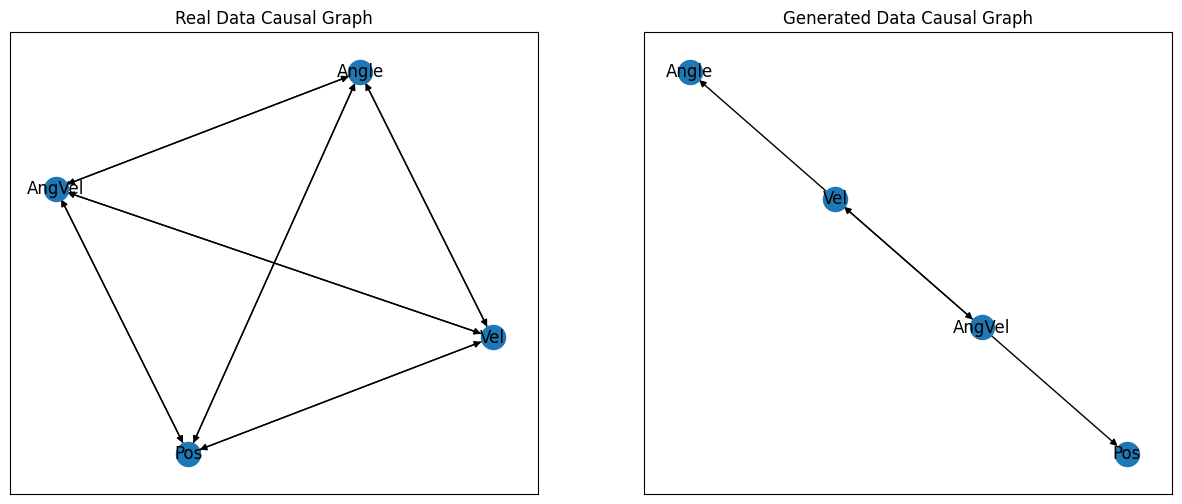

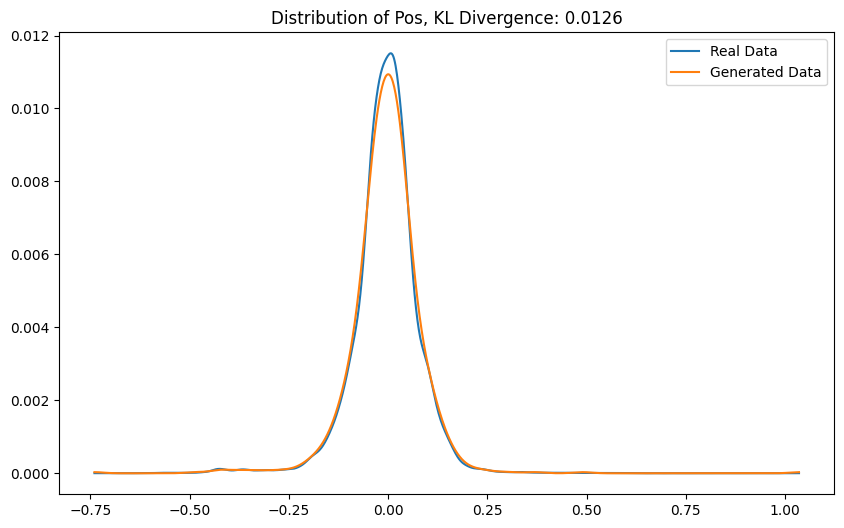

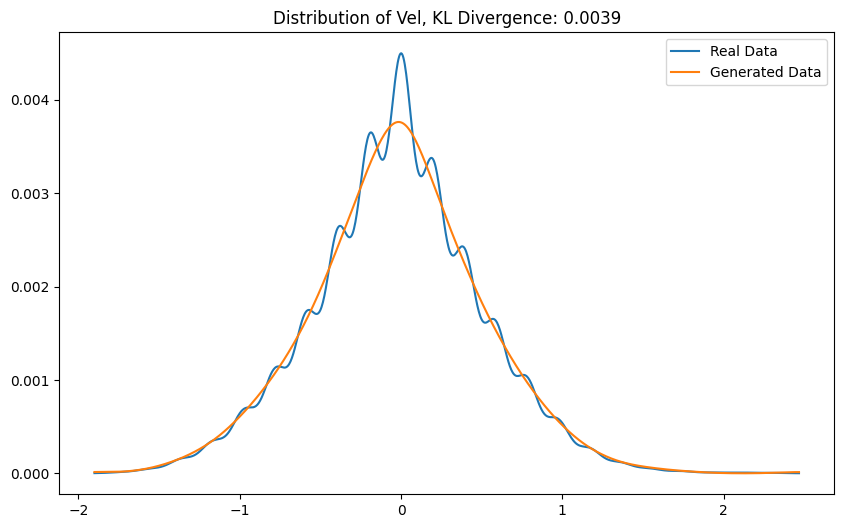

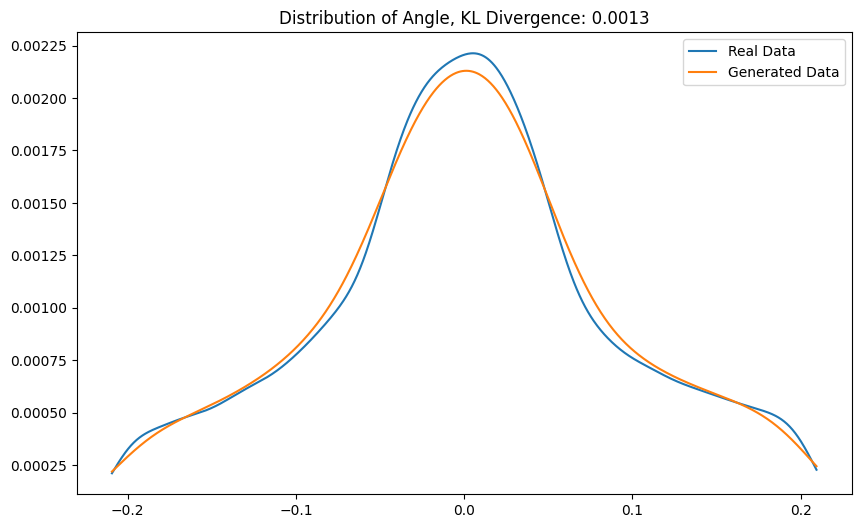

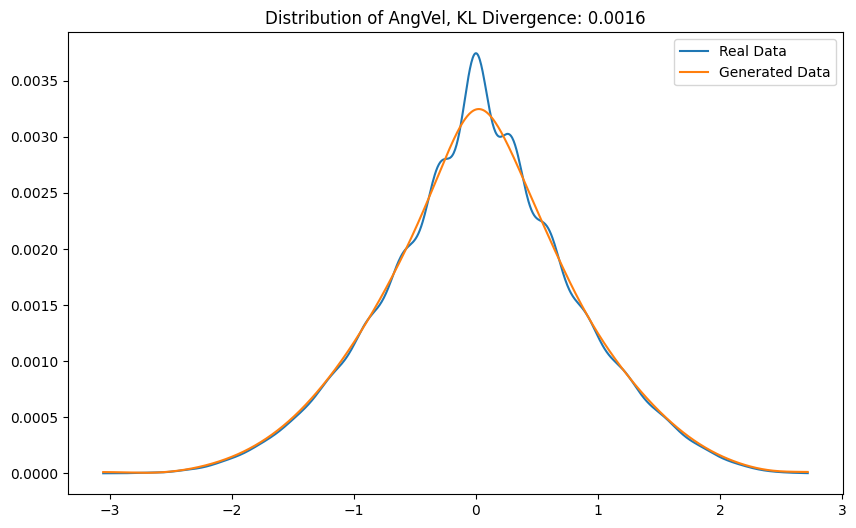

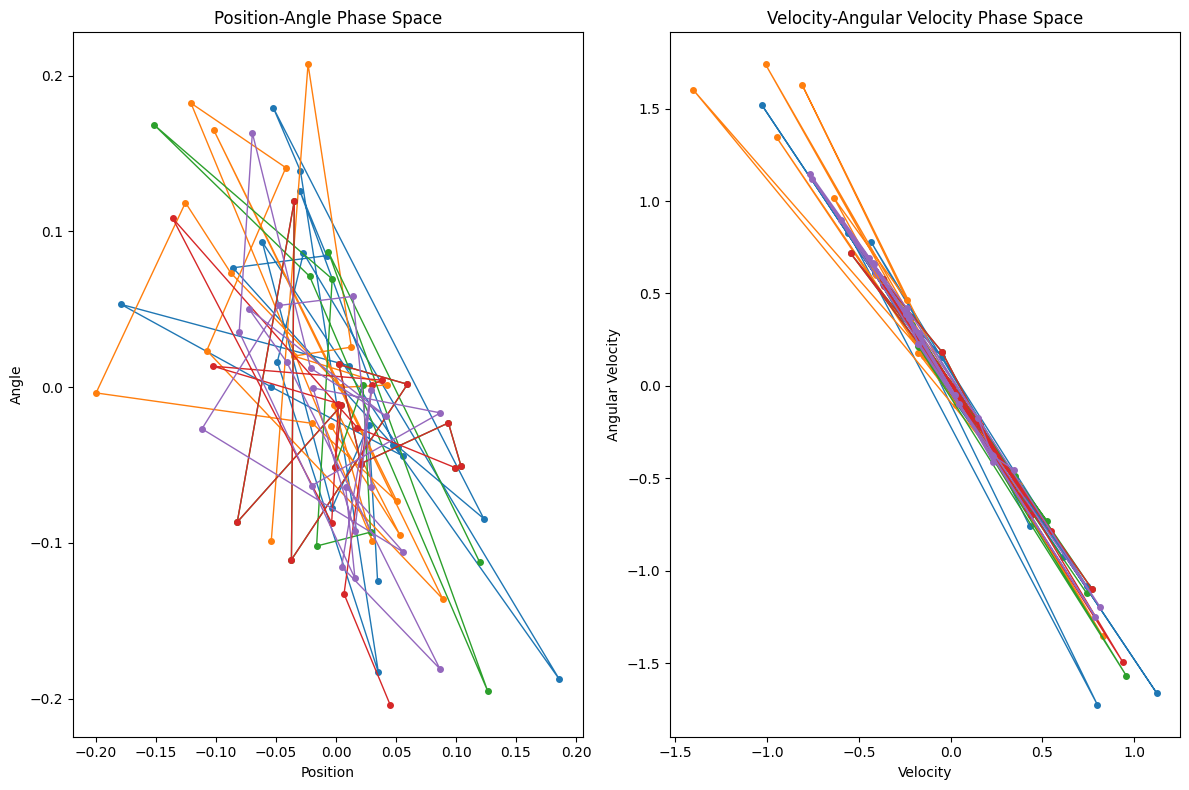

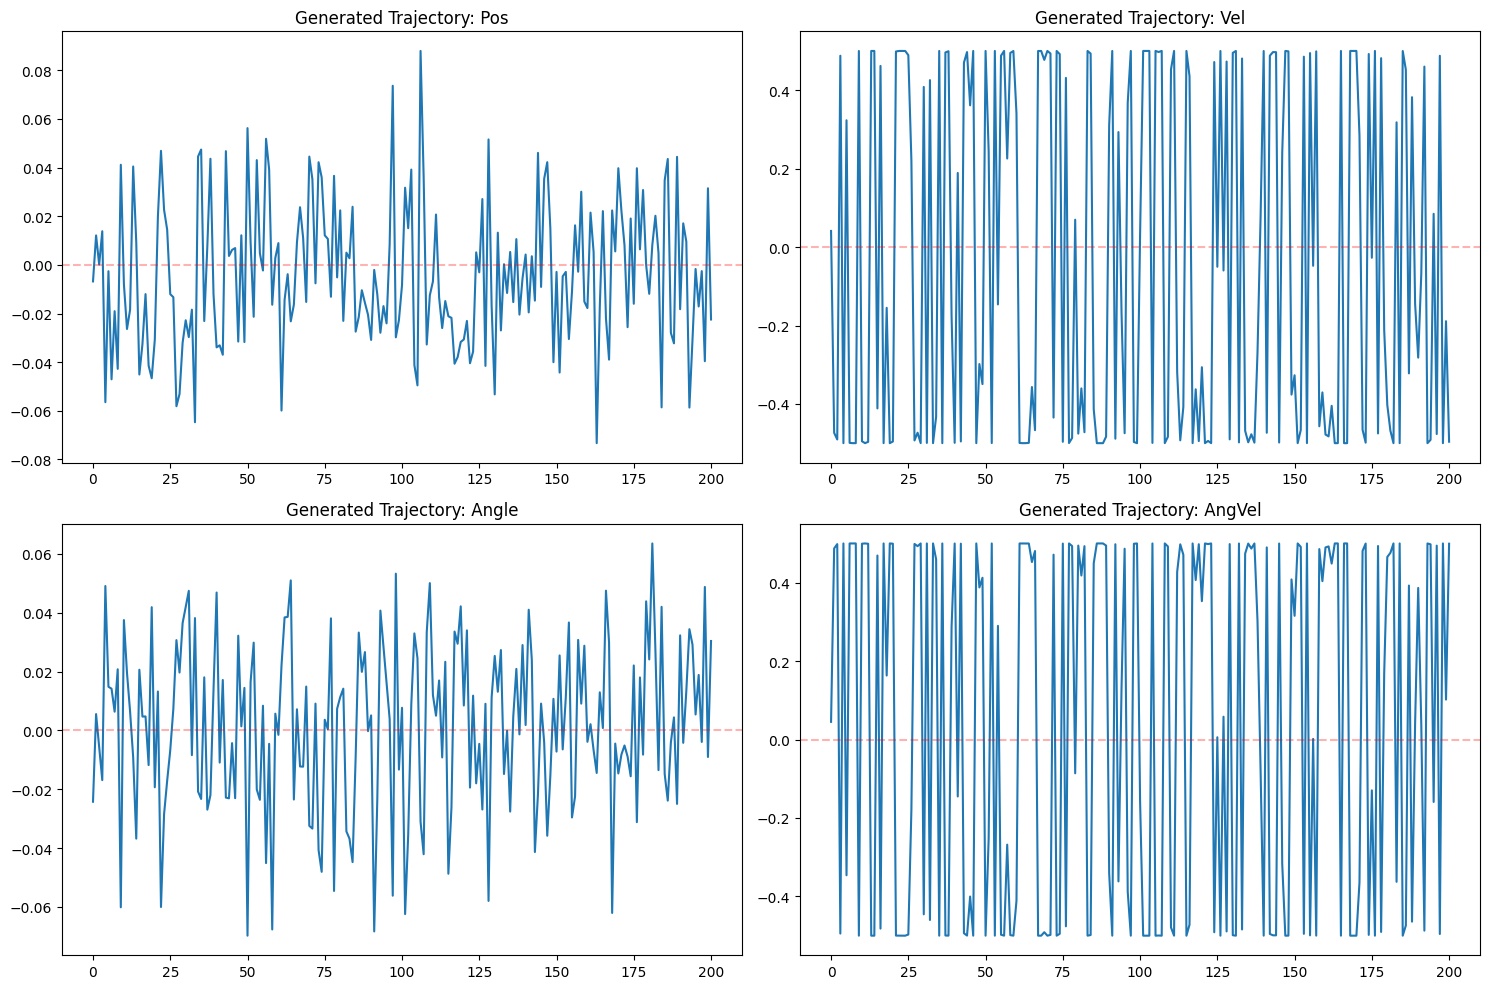

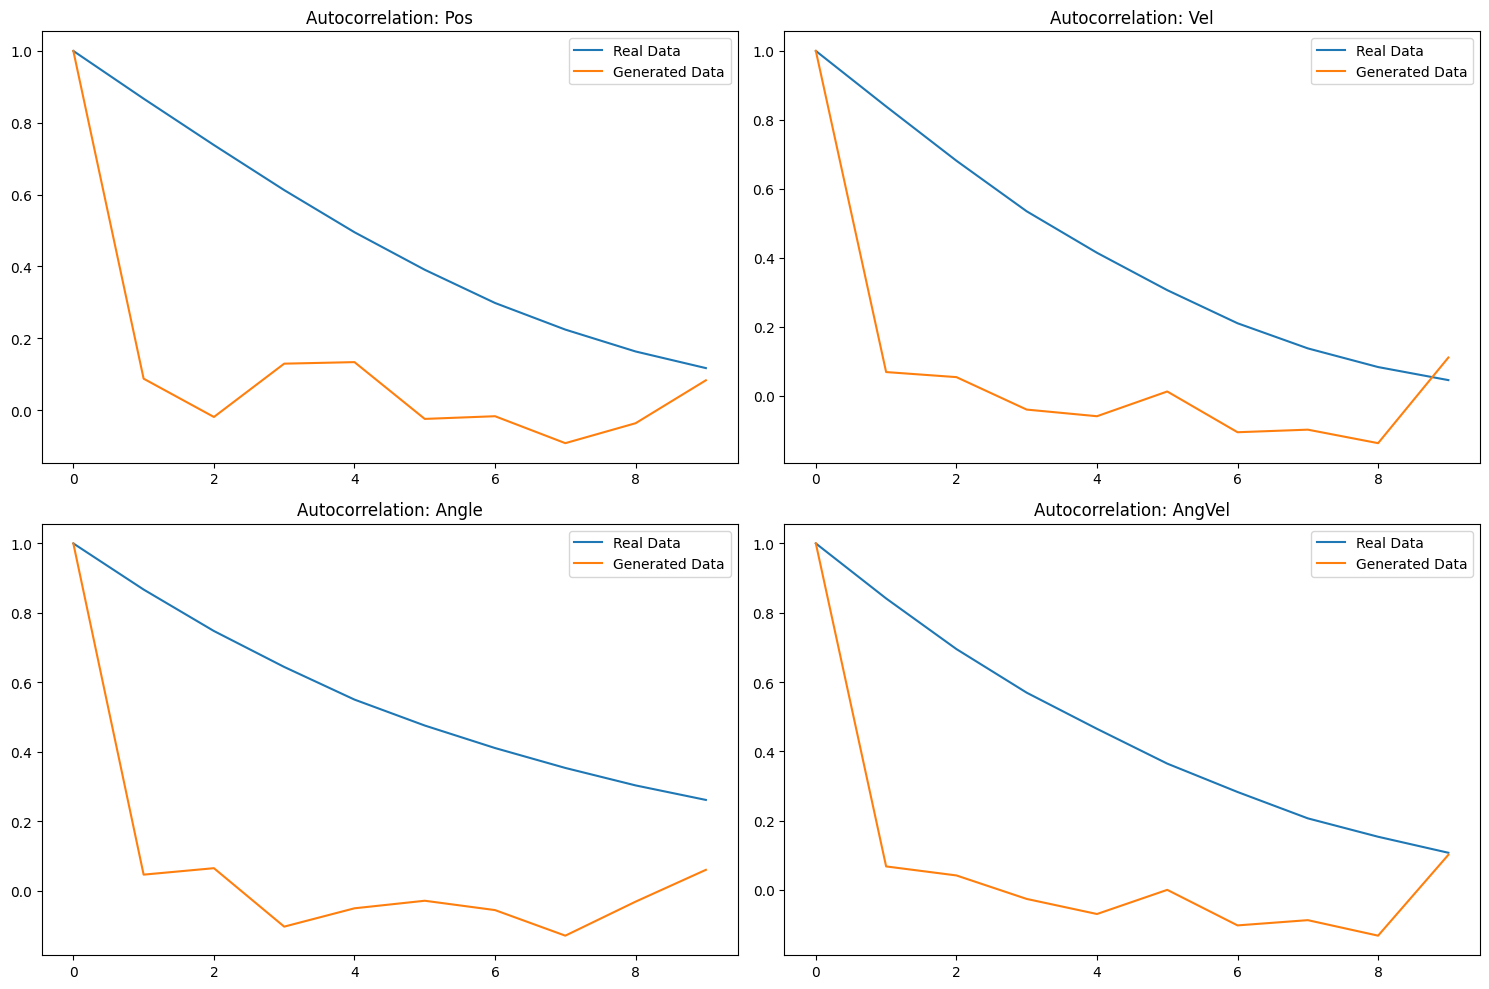

In [ ]:
def run_validation():
    print("1. Learning and comparing causal graphs...")
    # learn causal structure (this may take time)
    real_data = pd.read_csv("synthetic_game_data.csv")
    generated_data = pd.read_csv("generated_cartpole_states.csv")
    
    try:
        real_graph = learn_causal_graph(real_data)
        gen_graph = learn_causal_graph(generated_data)
        plot_causal_graphs(real_graph, gen_graph)
        print("✓ Causal graphs created and saved")
    except Exception as e:
        print(f"× Error in causal graph analysis: {e}")
    
    print("\n2. Evaluating distributions...")
    try:
        kl_results = evaluate_distributions()
        print("✓ Distribution analysis complete")
        print(f"KL Divergences: {kl_results}")
    except Exception as e:
        print(f"× Error in distribution analysis: {e}")
    
    print("\n3. Testing causal relationships...")
    try:
        causal_results = test_causal_relationships()
        print("✓ Causal relationship testing complete")
    except Exception as e:
        print(f"× Error in causal testing: {e}")
    
    print("\n4. Validating physics consistency...")
    try:
        physics_results = validate_physics_consistency()
        print("✓ Physics validation complete")
        print(f"Physics metrics: {physics_results}")
    except Exception as e:
        print(f"× Error in physics validation: {e}")
    
    print("\n5. Validating time dynamics...")
    try:
        traj_df = validate_time_dynamics()
        print("✓ Time dynamics validation complete")
    except Exception as e:
        print(f"× Error in time dynamics validation: {e}")
    
    print("\nValidation complete! Check the generated images and metrics.")


run_validation()